In [1]:
"""
Ideas, right now I'm optimizing over MAPE. Maar juist als je de overfit/underfit mee wilt nemen, kan het misschien
nuttig zijn om MPE te bekijken?
""";

#pip install /Users/Jasper/Downloads/fforma-master_new.zip
#!pip install git+https://github.com/FedericoGarza/tsfeatures


import scipy

import numpy as np
import pickle

import pandas as pd
from ESRNN.m4_data import prepare_m4_data, seas_dict
from ESRNN.utils_evaluation import evaluate_prediction_owa
from fforma import FFORMA

from functools import partial
import multiprocessing as mp
import glob

from tsfeatures import tsfeatures
from os import listdir
from os.path import isfile, join

In [2]:
%run models

# Forecasting MAPE over countries

In [3]:
columns_12 = ['hw_beta', 'unitroot_pp', 'alpha', 'arch_lm', 'flat_spots',
       'diff1_acf10', 'curvature', 'beta', 'garch_acf', 'seas_pacf',
       'seasonal_strength', 'hw_gamma', 'seas_acf1', 'x_pacf5', 'spike',
       'seasonal_period', 'peak', 'hurst', 'unitroot_kpss', 'trend', 'x_acf1',
       'diff2_acf1', 'x_acf10', 'entropy', 'diff2_acf10', 'e_acf10',
       'stability', 'garch_r2', 'trough', 'diff2x_pacf5', 'lumpiness',
       'diff1x_pacf5', 'arch_r2', 'nonlinearity', 'nperiods', 'diff1_acf1',
       'hw_alpha', 'arch_acf', 'linearity', 'e_acf1', 'series_length',
       'crossing_points']

columns_36 = ['alpha', 'arch_acf', 'arch_lm', 'arch_r2', 'beta', 'crossing_points',
       'curvature', 'diff1_acf1', 'diff1_acf10', 'diff1x_pacf5', 'diff2_acf1',
       'diff2_acf10', 'diff2x_pacf5', 'e_acf1', 'e_acf10', 'entropy',
       'flat_spots', 'garch_acf', 'garch_r2', 'hurst', 'hw_alpha', 'hw_beta',
       'hw_gamma', 'linearity', 'lumpiness', 'nonlinearity', 'nperiods',
       'peak', 'seas_acf1', 'seas_pacf', 'seasonal_period',
       'seasonal_strength', 'series_length', 'spike', 'stability', 'trend',
       'trough', 'unitroot_kpss', 'unitroot_pp', 'x_acf1', 'x_acf10',
       'x_pacf5']

In [4]:
"""
This funtion calculates the average MAPE of the forecasting models
in the model pool, along with the FFORMA prediction. It uses a 10_fold 
crossvalidation to confirm the results.

"""

def produce_PI_PF(filename, horizon, method, model_12, model_36, PI=False, ts_val = False):
    
    #Load data
    CBPI_country = pd.read_csv(filename)
    CBPI_country = CBPI_country.set_index('Week')

    #Put different training sets in a df
    tot_ts_list = []
    for i in range(10):
        tot_ts_list.append(list(CBPI_country[method][:-horizon - i]))
        
    CBPI_df = pd.DataFrame(tot_ts_list).T
    
    #Put all training datasets in a list
    ts_val_train = []
    for i in CBPI_df.columns:
        ts_val_train.append(CBPI_df[i].dropna().tolist())
    
    #Create multi_index
    multi_index = pd.MultiIndex.from_tuples(zip(np.repeat(list(range(1, 11)), horizon), list(range(1, horizon+1))*10), names = ['unique_id', 'ds'])
    
    #Create a df with the actual time series
    actual_df_new = pd.DataFrame(index = multi_index[:horizon*10]) 
    
    #Load models
    basic_models = {'Naive': Naive(), 'Naive2':Naive2(), 'SNaive': SeasonalNaive(), 'RWdrift': RandomWalkDrift(), 'ETS':ETS(),
           'AutoArima': AutoArima(), 'TBATS':TBATSFF(), 'DTrendS':DTRENDS(), 'RWDriftS':RWDriftS(), 'LLevelS': LLevelS(), 'LLDTrends':LLDTRENDS()}
    

    #Fill the actual df
    for i in list(basic_models.keys()):
        pred_tot = []
        pred_tot += list(CBPI_country[-horizon:][method])
        for j in range(1, 10):
            pred_tot += list(CBPI_country[-horizon - j : - j][method])
        actual_df_new[i] =  pred_tot

    #add a column for fforma    
    actual_df_new['fforma'] = actual_df_new['Naive']

    #Get all the ts feats
    ts_val_train_feats = [x[-36:] for x in ts_val_train] #Neeeds to be adjusted for other horizons

    train_feats_new = pd.DataFrame()
    ts_val_cpi = pd.DataFrame(pd.DataFrame(ts_val_train_feats).stack())
    #ts_val_cpi = pd.DataFrame(pd.DataFrame(ts_val_train).stack())
    ts_val_cpi = ts_val_cpi.rename_axis(index = ['unique_id', 'ds'])
    ts_val_cpi = ts_val_cpi.rename(columns = {0:'y'})
    ts_val_cpi = tsfeatures(ts_val_cpi, 12)

    if horizon==12:
        model_lgb = model_12
        weights_CBPI = scipy.special.softmax(model_lgb.predict(ts_val_cpi[columns_12]), axis = 1)
    else:
        model_36_lgb = model_36
        weights_CBPI = scipy.special.softmax(model_36_lgb.predict(ts_val_cpi[columns_36]), axis = 1)
        
    if ts_val:
        return ts_val_cpi, weights_CBPI
    



    #Train the basic models
    ts_val_train_preds = trainBasicModels().train(basic_models, ts_val_train, 12).predict(horizon, CI = False)

    #Create a df for the predictions
    preds_df_new = pd.DataFrame(index = multi_index[:horizon*10]) 
    
    #Put actual predictions in the dataframe
    k=0
    for i in list(basic_models.keys()):
        pred_tot = []
        for j in ts_val_train_preds:
            pred_tot += list(j[k])
        preds_df_new[i]  = pred_tot
        k += 1


    preds_df_new['fforma'] = (np.repeat(weights_CBPI, horizon, axis = 0)*preds_df_new).sum(axis = 1)

    actual_df_new.index = preds_df_new.index

    errors_CBPI = np.abs(actual_df_new-preds_df_new)*100/actual_df_new #Dataframe with the MAPE

    weights_CBPI_df = pd.DataFrame(weights_CBPI)

    weights_CBPI_df.columns = preds_df_new.columns[:-1]   
    PF_result = errors_CBPI.groupby('unique_id')[errors_CBPI.columns].mean().describe().round(2)
    
    if PI:
    #Now the CI

        basic_models = {'AutoArima': AutoArima(), 'TBATS':TBATSFF(), 'DTrendS':DTRENDS(), 'RWDriftS':RWDriftS(),'LLevelS': LLevelS(), 'LLDTrends':LLDTRENDS()}
        ts_val_train_preds = trainBasicModels().train(basic_models, ts_val_train, 12).predict(horizon, CI = True)

        interval_df_new = pd.DataFrame(index = multi_index[:horizon*10]) 

        #Put actual predictions in the dataframe
        k=0
        for i in list(basic_models.keys()):
            pred_tot = []
            for j in ts_val_train_preds:
                pred_tot += list(j[k])
            interval_df_new[i]  = pred_tot
            k += 1

        #Interval width
        for i in interval_df_new.columns:
            interval_df_new[i] = interval_df_new[i].map(lambda x: (x[1]-x[0])/2)

        pred_weights_CI_new = scipy.special.softmax(model_CI_12.predict(ts_val_cpi), axis = 1)

        interval_df_new['fforma'] = (np.repeat(pred_weights_CI_new, horizon, axis = 0)*interval_df_new).sum(axis = 1)

        preds_df_new_int = preds_df_new[interval_df_new.columns]

        def get_interval(pd_series):
            Name = pd_series.name
            difference_series = interval_df_new[Name]
            return [[x-y, x+y] for (x,y) in zip(list(pd_series), list(difference_series))]  

        for i in preds_df_new_int.columns:
            preds_df_new_int[i] = get_interval(preds_df_new_int[i])

        actual_df_new_int = actual_df_new[preds_df_new_int.columns]   

        def get_MSIS_value(pd_series):
            Name = pd_series.name
            CI_series = list(preds_df_new_int[Name])

            return [(y[1]-y[0]) +(2/0.05)*(y[0] - x) if x<y[0] else (y[1]-y[0]) +(2/0.05)*(x - y[1]) if x>y[1] else y[1]-y[0] for (x, y) in zip(list(pd_series), CI_series)]

        for i in actual_df_new_int.columns:
            actual_df_new_int[i] = get_MSIS_value(actual_df_new_int[i])


        index_seas_diff_CI = pd.MultiIndex.from_tuples(zip(np.repeat(list(range(1, 11)), 36), list(range(1, 37))*10), names = ['unique_id', 'ds'])
        errors_df_insample_full_seas_diff_CI = pd.DataFrame(index = index_seas_diff_CI, columns = actual_df_new_int.columns)

        pred_tot = []     
        pred_tot += list(CBPI_country[-horizon-36:-horizon][method])
        for i in range(1, 10):
                pred_tot += list(CBPI_country[-horizon - i -36 : - i-horizon][method])
        for k in errors_df_insample_full_seas_diff_CI.columns:
            errors_df_insample_full_seas_diff_CI[k] = pred_tot

        errors_df_insample_full_seas_diff_CI = errors_df_insample_full_seas_diff_CI.groupby(level=0).diff(12).dropna()
        errors_df_insample_full_seas_diff_CI = np.abs(errors_df_insample_full_seas_diff_CI)
        errors_df_insample_full_seas_diff_CI = errors_df_insample_full_seas_diff_CI.groupby('unique_id').mean()

        actual_df_new_int = actual_df_new_int/errors_df_insample_full_seas_diff_CI

        PI_result = actual_df_new_int.groupby('unique_id').mean().describe()
        return PF_result, PI_result,
    else:
        return PF_result

## Horizon 12 months

In [5]:
#Rerun the analysis the analaysis for the different countries and show the MAPE
"""
DE_TD_new = produce_PI_PF('dataset_DE_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 

UK_TD_new = produce_PI_PF('dataset_UK_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
IT_TD_new = produce_PI_PF('dataset_IT_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
FR_TD_new = produce_PI_PF('dataset_FR_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
CH_TD_new = produce_PI_PF('dataset_CH_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
ES_TD_new = produce_PI_PF('dataset_ES_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
PT_TD_new = produce_PI_PF('dataset_PT_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 

((DE_TD_new + UK_TD_new + IT_TD_new + FR_TD_new + CH_TD_new + ES_TD_new + PT_TD_new)/7).round(2)""";

In [105]:
"""UK_TD_new.to_pickle('./Results/UK_TD_new_LP.pkl')
DE_TD_new.to_pickle('./Results/DE_TD_new_LP.pkl')
IT_TD_new.to_pickle('./Results/IT_TD_new_LP.pkl')
FR_TD_new.to_pickle('./Results/FR_TD_new_LP.pkl')
CH_TD_new.to_pickle('./Results/CH_TD_new_LP.pkl')
ES_TD_new.to_pickle('./Results/ES_TD_new_LP.pkl')
PT_TD_new.to_pickle('./Results/PT_TD_new_LP.pkl')
""";

In [6]:
UK_TD_new = pd.read_pickle('./Results/UK_TD_new_LP.pkl')
DE_TD_new = pd.read_pickle('./Results/DE_TD_new_LP.pkl')
IT_TD_new = pd.read_pickle('./Results/IT_TD_new_LP.pkl')
FR_TD_new = pd.read_pickle('./Results/FR_TD_new_LP.pkl')
CH_TD_new = pd.read_pickle('./Results/CH_TD_new_LP.pkl')
ES_TD_new = pd.read_pickle('./Results/ES_TD_new_LP.pkl')
PT_TD_new = pd.read_pickle('./Results/PT_TD_new_LP.pkl')


In [7]:
((DE_TD_new + UK_TD_new + IT_TD_new + FR_TD_new + CH_TD_new + ES_TD_new + PT_TD_new)/7).round(2)

,Naive,Naive2,SNaive,RWdrift,ETS,AutoArima,TBATS,DTrendS,RWDriftS,LLevelS,LLDTrends,fforma
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,2.99,2.99,2.90,3.13,2.94,5.45,2.74,3.13,2.70,2.53,2.66,2.57
std,1.25,1.25,0.52,1.37,1.19,2.21,0.88,1.09,1.10,0.94,1.08,0.87
min,1.64,1.64,2.30,1.67,1.66,2.42,1.72,1.91,1.44,1.42,1.48,1.58
25%,2.07,2.07,2.49,2.17,2.09,3.70,2.05,2.22,1.86,1.83,1.82,1.89
50%,2.69,2.69,2.81,2.78,2.68,5.58,2.61,2.91,2.43,2.37,2.38,2.39
75%,3.65,3.65,3.23,3.98,3.57,6.95,3.27,3.96,3.36,3.01,3.38,3.11
max,5.38,5.38,3.76,5.61,5.23,8.95,4.35,4.86,4.67,4.30,4.56,4.18


## Horizon 36 months

In [9]:
"""#Rerun the analysis the analaysis for the different countries and show the MAPE

DE_TD_new_36 = produce_PI_PF('dataset_DE_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 

UK_TD_new_36 = produce_PI_PF('dataset_UK_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
IT_TD_new_36 = produce_PI_PF('dataset_IT_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
FR_TD_new_36 = produce_PI_PF('dataset_FR_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
CH_TD_new_36 = produce_PI_PF('dataset_CH_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
ES_TD_new_36 = produce_PI_PF('dataset_ES_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 
PT_TD_new_36 = produce_PI_PF('dataset_PT_index.csv', 36, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=False) 

((DE_TD_new_36 + UK_TD_new_36 + IT_TD_new_36 + FR_TD_new_36 + CH_TD_new_36 + ES_TD_new_36 + PT_TD_new_36)/7).round(2)""";

In [10]:
"""UK_TD_new_36.to_pickle('./Results/UK_TD_new_LP_36.pkl')
DE_TD_new_36.to_pickle('./Results/DE_TD_new_LP_36.pkl')
IT_TD_new_36.to_pickle('./Results/IT_TD_new_LP_36.pkl')
FR_TD_new_36.to_pickle('./Results/FR_TD_new_LP_36.pkl')
CH_TD_new_36.to_pickle('./Results/CH_TD_new_LP_36.pkl')
ES_TD_new_36.to_pickle('./Results/ES_TD_new_LP_36.pkl')
PT_TD_new_36.to_pickle('./Results/PT_TD_new_LP_36.pkl')""";

In [11]:
UK_TD_new_36 = pd.read_pickle('./Results/UK_TD_new_LP_36.pkl')
DE_TD_new_36 = pd.read_pickle('./Results/DE_TD_new_LP_36.pkl')
IT_TD_new_36 = pd.read_pickle('./Results/IT_TD_new_LP_36.pkl')
FR_TD_new_36 = pd.read_pickle('./Results/FR_TD_new_LP_36.pkl')
CH_TD_new_36 = pd.read_pickle('./Results/CH_TD_new_LP_36.pkl')
ES_TD_new_36 = pd.read_pickle('./Results/ES_TD_new_LP_36.pkl')
PT_TD_new_36 = pd.read_pickle('./Results/PT_TD_new_LP_36.pkl')


In [12]:
((DE_TD_new_36 + UK_TD_new_36 + IT_TD_new_36 + FR_TD_new_36 + CH_TD_new_36 + ES_TD_new_36 + PT_TD_new_36)/7).round(2)

,Naive,Naive2,SNaive,RWdrift,ETS,AutoArima,TBATS,DTrendS,RWDriftS,LLevelS,LLDTrends,fforma
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,5.12,5.12,4.88,9.28,4.72,13.76,6.52,11.07,8.21,4.68,8.33,6.04
std,1.84,1.84,0.59,3.44,1.32,9.89,2.64,1.57,2.49,1.23,2.39,1.88
min,2.63,2.63,4.04,4.36,2.98,3.44,2.98,8.99,4.74,3.07,4.90,3.65
25%,3.85,3.85,4.47,7.16,3.80,6.91,4.70,9.83,6.42,3.88,6.72,4.80
50%,5.08,5.08,4.88,9.16,4.61,11.78,6.63,11.14,8.11,4.54,8.21,5.58
75%,6.25,6.25,5.24,11.49,5.39,16.50,7.57,11.93,9.49,5.34,9.97,7.19
max,8.14,8.14,5.82,14.76,7.10,32.24,11.05,13.68,12.47,6.91,12.11,9.38


# Show the forecasts

In [13]:
"""
Function below again produces the predictions, but now does NOT
include crossvalidation, so that we can see the actual predictions
"""
def produce_PF_plot(filename, method, model_12, model_36, horizon, CI=False):
    #Load data
    CBPI_country = pd.read_csv(filename)
    CBPI_country = CBPI_country.set_index('Week')
    CBPI_country = CBPI_country[[method]]
    tot_ts_list = []
    for i in range(1):
        tot_ts_list.append(list(CBPI_country[method][:-horizon - i]))

    CBPI_df = pd.DataFrame(tot_ts_list).T

    #Load models
    basic_models = {'Naive': Naive(), 'Naive2':Naive2(), 'SNaive': SeasonalNaive(), 'RWdrift': RandomWalkDrift(), 'ETS':ETS(),
           'AutoArima': AutoArima(), 'TBATS':TBATSFF(), 'DTrendS':DTRENDS(), 'RWDriftS':RWDriftS(), 'LLevelS': LLevelS(), 'LLDTrends':LLDTRENDS()}

    #Put all training datasets in a list
    ts_val_train = []
    for i in CBPI_df.columns:
        ts_val_train.append(CBPI_df[i].dropna().tolist())

    #Train the basic models
    ts_val_train_preds = trainBasicModels().train(basic_models, ts_val_train, 12).predict(horizon, CI = False)

    #Create multi_index
    multi_index = pd.MultiIndex.from_tuples(zip(np.repeat(list(range(1, 2)), horizon), list(range(1, horizon+1))*1), names = ['unique_id', 'ds'])

    #Create a df for the predictions
    preds_df_new = pd.DataFrame(index = multi_index[:horizon*1]) 

    #Put actual predictions in the dataframe
    k=0
    for i in list(basic_models.keys()):
        pred_tot = []
        for j in ts_val_train_preds:
            pred_tot += list(j[k])
        preds_df_new[i]  = pred_tot
        k += 1

    #Create a df with the actual time series
    actual_df_new = pd.DataFrame(index = multi_index[:horizon*1]) 

    #Fill the actual df
    for i in list(basic_models.keys()):
        pred_tot = []
        pred_tot += list(CBPI_country[-horizon:][method])
    #    for j in range(1):
    #        pred_tot += list(CBPI_country[-horizon - j : - j][method])
        actual_df_new[i] =  pred_tot

    #add a column for fforma    
    actual_df_new['fforma'] = actual_df_new['Naive']

    #Get all the ts feats
    ts_val_train_feats = [x[-36:] for x in ts_val_train] #Neeeds to be adjusted for other horizons

    train_feats_new = pd.DataFrame()
    ts_val_cpi = pd.DataFrame(pd.DataFrame(ts_val_train_feats).stack())
    ts_val_cpi = ts_val_cpi.rename_axis(index = ['unique_id', 'ds'])
    ts_val_cpi = ts_val_cpi.rename(columns = {0:'y'})
    ts_val_cpi = tsfeatures(ts_val_cpi, 12)

    if horizon==12:
        method_short = model_12
        weights_CBPI = scipy.special.softmax(method_short.predict(ts_val_cpi[columns_12]), axis = 1)
    else:
        method_long = model_36
        weights_CBPI = scipy.special.softmax(method_long.predict(ts_val_cpi[columns_36]), axis = 1)
    #print(pd.DataFrame(data = weights_CBPI, columns = preds_df_new.columns).describe())
    preds_df_new['fforma'] = (np.repeat(weights_CBPI, horizon, axis = 0)*preds_df_new).sum(axis = 1)

    for i in preds_df_new.columns:
        if i not in ['Naive', 'DTrendS', 'RWDriftS', 'LLDTrends', 'RWdrift']:
        #if i not in ['Naive', 'RWDriftS', 'LLDTrends', 'RWdrift']:
            #print(i)
            series_cur = pd.Series(index = CBPI_country.index[-horizon:], data = preds_df_new[i].tolist())
            CBPI_country[i] = series_cur
    CBPI_country.index.name = 'Time'
    
    if CI:
        basic_models = {'AutoArima': AutoArima(), 'TBATS':TBATSFF(), 'DTrendS':DTRENDS(), 'RWDriftS':RWDriftS(),'LLevelS': LLevelS(), 'LLDTrends':LLDTRENDS()}
        ts_val_train_preds = trainBasicModels().train(basic_models, ts_val_train, 12).predict(horizon, CI = True)
        interval_df_new = pd.DataFrame(index = multi_index[:horizon*1]) 
        
        #Put actual predictions in the dataframe
        k=0
        for i in list(basic_models.keys()):
            pred_tot = []
            for j in ts_val_train_preds:
                pred_tot += list(j[k])
            interval_df_new[i]  = pred_tot
            k += 1        

        for i in interval_df_new.columns:
            interval_df_new[i] = interval_df_new[i].map(lambda x: (x[1]-x[0])/2)
        
        pred_weights_CI_new = scipy.special.softmax(model_CI_12.predict(ts_val_cpi[columns_12]), axis = 1)
        
        interval_df_new['fforma'] = (np.repeat(pred_weights_CI_new, horizon, axis = 0)*interval_df_new).sum(axis = 1)
        preds_df_new_int = preds_df_new[interval_df_new.columns]
        
        def get_interval(pd_series):
            Name = pd_series.name
            difference_series = interval_df_new[Name]
            return [[x-y, x+y] for (x,y) in zip(list(pd_series), list(difference_series))]  

        for i in preds_df_new_int.columns:
            preds_df_new_int[i] = get_interval(preds_df_new_int[i])
    
    if CI:
        return CBPI_country, preds_df_new_int
    else:
        return CBPI_country


In [14]:
#Produce the df for DE
DE_plot_TD = produce_PF_plot('dataset_DE_index.csv', 'Time Dummy method', 
                             pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                             pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),12)


100%|██████████| 1/1 [00:00<00:00, 21.18it/s]

In [15]:
"""
Function that produces the plot
"""
import matplotlib.pyplot as plt

def final_plot(df, country, method, save = False):
    horizon = len(df[df.columns[1]].dropna())
    nr_cols = df.columns
    linewidths = [4] + [2]*(len(nr_cols)-1)
    fig, ax = plt.subplots()
    for col, lw in zip(df.columns,linewidths):
        df[col].iloc[-int(horizon*1.5):].plot(lw=lw, ax=ax, figsize = (15, 7), legend = [list(range(9))])
    plt.ylabel('Index')
    plt.ylim((0.83, 1.09))
    plt.legend(loc='lower left')
    if save:
        fig.savefig('{}_{}.png'.format(method, country), dpi = 300)


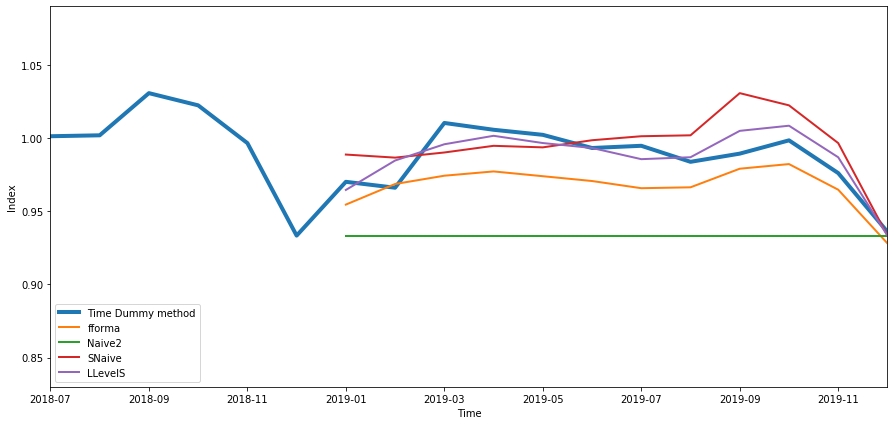

In [16]:
final_plot(DE_plot_TD[['Time Dummy method', 'fforma', 'Naive2', 'SNaive', 'LLevelS']], 'DE', 'Time Dummy', save = False)

In [17]:
def final_plot_CI(df1, df2, country, method, save = False):

    under_s = [x[0] for x in df2.fforma]
    over_s = [x[1] for x in df2.fforma]
    
    df1 = df1[['Time Dummy method', 'fforma']]
    #print(df1)
    horizon = len(df1[df1.columns[1]].dropna())
    nr_cols = df1.columns
    linewidths = [4] + [2]*(len(nr_cols)-1)
    fig, ax = plt.subplots()
    for col, lw in zip(df1.columns,linewidths):
        df1[col].iloc[-int(horizon*1.5):].plot(lw=lw, ax=ax, figsize = (15, 7), legend = [list(range(9))])
    plt.fill_between(df1.index[-18:], df1['Time Dummy method'][-18:-12].tolist() + under_s , df1['Time Dummy method'][-18:-12].tolist() + over_s, color='orange', alpha=.1)
    plt.ylabel('Index')
    plt.ylim((0.83, 1.09))
    plt.legend(loc='lower left')    
    
    if save:
        fig.savefig('{}_{}_CI.png'.format(method, country), dpi = 300)

In [18]:
model_CI_12 = pickle.load(open('./Models/model_CI_12.pickle.dat', 'rb'))

CBPI_pred, CBPI_PI = produce_PF_plot('dataset_DE_index.csv', 'Time Dummy method', 
                             pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                             pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),12, CI=True)


100%|██████████| 1/1 [00:00<00:00, 22.67it/s]

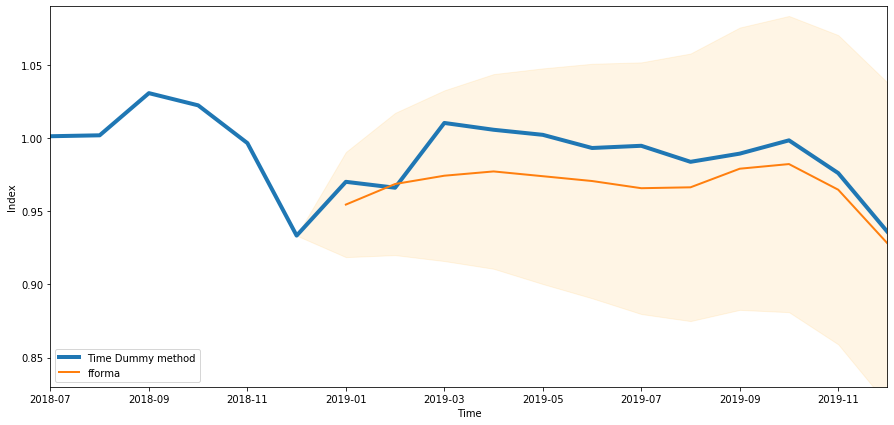

In [19]:
final_plot_CI(CBPI_pred, CBPI_PI, 'DE', 'Time Dummy', save = False)

# Now in terms of prediction interval measure MSIS

In [121]:
def produce_MSIS(filename, horizon, method, model_12, model_36, PI=True):
    
    #Load data
    CBPI_country = pd.read_csv(filename)
    CBPI_country = CBPI_country.set_index('Week')

    #Put different training sets in a df
    tot_ts_list = []
    for i in range(10):
        tot_ts_list.append(list(CBPI_country[method][:-horizon - i]))
        
    CBPI_df = pd.DataFrame(tot_ts_list).T
    
    #Load models
    basic_models = {'Naive': Naive(), 'Naive2':Naive2(), 'SNaive': SeasonalNaive(), 'RWdrift': RandomWalkDrift(), 'ETS':ETS(),
           'AutoArima': AutoArima(), 'TBATS':TBATSFF(), 'DTrendS':DTRENDS(), 'RWDriftS':RWDriftS(), 'LLevelS': LLevelS(), 'LLDTrends':LLDTRENDS()}

    #Put all training datasets in a list
    ts_val_train = []
    for i in CBPI_df.columns:
        ts_val_train.append(CBPI_df[i].dropna().tolist())

    #Train the basic models
    ts_val_train_preds = trainBasicModels().train(basic_models, ts_val_train, 12).predict(horizon, CI = False)

    #Create multi_index
    multi_index = pd.MultiIndex.from_tuples(zip(np.repeat(list(range(1, 11)), horizon), list(range(1, horizon+1))*10), names = ['unique_id', 'ds'])

    #Create a df for the predictions
    preds_df_new = pd.DataFrame(index = multi_index[:horizon*10]) 
    
    #Put actual predictions in the dataframe
    k=0
    for i in list(basic_models.keys()):
        pred_tot = []
        for j in ts_val_train_preds:
            pred_tot += list(j[k])
        preds_df_new[i]  = pred_tot
        k += 1

    #Create a df with the actual time series
    actual_df_new = pd.DataFrame(index = multi_index[:horizon*10]) 

    #Fill the actual df
    for i in list(basic_models.keys()):
        pred_tot = []
        pred_tot += list(CBPI_country[-horizon:][method])
        for j in range(1, 10):
            pred_tot += list(CBPI_country[-horizon - j : - j][method])
        actual_df_new[i] =  pred_tot

    #add a column for fforma    
    actual_df_new['fforma'] = actual_df_new['Naive']

    #Get all the ts feats
    ts_val_train_feats = [x[-36:] for x in ts_val_train] #Neeeds to be adjusted for other horizons

    train_feats_new = pd.DataFrame()
    ts_val_cpi = pd.DataFrame(pd.DataFrame(ts_val_train_feats).stack())
    #ts_val_cpi = pd.DataFrame(pd.DataFrame(ts_val_train).stack())
    ts_val_cpi = ts_val_cpi.rename_axis(index = ['unique_id', 'ds'])
    ts_val_cpi = ts_val_cpi.rename(columns = {0:'y'})
    ts_val_cpi = tsfeatures(ts_val_cpi, 12)

    if horizon==12:
        model_lgb = model_12
        weights_CBPI = scipy.special.softmax(model_lgb.predict(ts_val_cpi[columns_12]), axis = 1)
    else:
        model_36_lgb = model_36
        weights_CBPI = scipy.special.softmax(model_36_lgb.predict(ts_val_cpi[columns_36]), axis = 1)

    preds_df_new['fforma'] = (np.repeat(weights_CBPI, horizon, axis = 0)*preds_df_new).sum(axis = 1)

    actual_df_new.index = preds_df_new.index

    errors_CBPI = np.abs(actual_df_new-preds_df_new)*100/actual_df_new #Dataframe with the MAPE

    weights_CBPI_df = pd.DataFrame(weights_CBPI)

    weights_CBPI_df.columns = preds_df_new.columns[:-1]   
    PF_result = errors_CBPI.groupby('unique_id')[errors_CBPI.columns].mean().describe().round(2)
    
    if PI:
    #Now the CI

        basic_models = {'AutoArima': AutoArima(), 'TBATS':TBATSFF(), 'DTrendS':DTRENDS(), 'RWDriftS':RWDriftS(),'LLevelS': LLevelS(), 'LLDTrends':LLDTRENDS()}
        ts_val_train_preds = trainBasicModels().train(basic_models, ts_val_train, 12).predict(horizon, CI = True)

        interval_df_new = pd.DataFrame(index = multi_index[:horizon*10]) 

        #Put actual predictions in the dataframe
        k=0
        for i in list(basic_models.keys()):
            pred_tot = []
            for j in ts_val_train_preds:
                pred_tot += list(j[k])
            interval_df_new[i]  = pred_tot
            k += 1

        #Interval width
        for i in interval_df_new.columns:
            interval_df_new[i] = interval_df_new[i].map(lambda x: (x[1]-x[0])/2)

        pred_weights_CI_new = scipy.special.softmax(model_CI_12.predict(ts_val_cpi[columns_12]), axis = 1)

        interval_df_new['fforma'] = (np.repeat(pred_weights_CI_new, horizon, axis = 0)*interval_df_new).sum(axis = 1)

        preds_df_new_int = preds_df_new[interval_df_new.columns]

        def get_interval(pd_series):
            Name = pd_series.name
            difference_series = interval_df_new[Name]
            return [[x-y, x+y] for (x,y) in zip(list(pd_series), list(difference_series))]  

        for i in preds_df_new_int.columns:
            preds_df_new_int[i] = get_interval(preds_df_new_int[i])

        actual_df_new_int = actual_df_new[preds_df_new_int.columns]   

        def get_MSIS_value(pd_series):
            Name = pd_series.name
            CI_series = list(preds_df_new_int[Name])

            return [(y[1]-y[0]) +(2/0.05)*(y[0] - x) if x<y[0] else (y[1]-y[0]) +(2/0.05)*(x - y[1]) if x>y[1] else y[1]-y[0] for (x, y) in zip(list(pd_series), CI_series)]

        for i in actual_df_new_int.columns:
            actual_df_new_int[i] = get_MSIS_value(actual_df_new_int[i])

        
        index_seas_diff_CI = pd.MultiIndex.from_tuples(zip(np.repeat(list(range(1, 11)), 36), list(range(1, 37))*10), names = ['unique_id', 'ds'])
        errors_df_insample_full_seas_diff_CI = pd.DataFrame(index = index_seas_diff_CI, columns = actual_df_new_int.columns)

        pred_tot = []     
        pred_tot += list(CBPI_country[-horizon-36:-horizon][method])
        for i in range(1, 10):
                pred_tot += list(CBPI_country[-horizon - i -36 : - i-horizon][method])
        for k in errors_df_insample_full_seas_diff_CI.columns:
            errors_df_insample_full_seas_diff_CI[k] = pred_tot

        errors_df_insample_full_seas_diff_CI = errors_df_insample_full_seas_diff_CI.groupby(level=0).diff(12).dropna()
        errors_df_insample_full_seas_diff_CI = np.abs(errors_df_insample_full_seas_diff_CI)
        errors_df_insample_full_seas_diff_CI = errors_df_insample_full_seas_diff_CI.groupby('unique_id').mean()

        actual_df_new_int = actual_df_new_int/errors_df_insample_full_seas_diff_CI

        PI_result = actual_df_new_int.groupby('unique_id').mean().describe()
        return PF_result, PI_result

In [20]:
"""DE_TD_CI = produce_MSIS('dataset_DE_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]

ES_TD_CI = produce_MSIS('dataset_ES_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]

IT_TD_CI = produce_MSIS('dataset_IT_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]

UK_TD_CI = produce_MSIS('dataset_UK_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]

CH_TD_CI = produce_MSIS('dataset_CH_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]

PT_TD_CI = produce_MSIS('dataset_PT_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]

FR_TD_CI = produce_MSIS('dataset_FR_index.csv', 12, 'Time Dummy method',
                          pickle.load(open('./Models/model_3yr_120.pickle.dat', 'rb')),
                          pickle.load(open('./Models/model_36_150.pickle.dat', 'rb')),
                          PI=True)[1]""";

In [22]:
"""DE_TD_CI.to_pickle('./Results/DE_TD_CI.pkl')
UK_TD_CI.to_pickle('./Results/UK_TD_CI.pkl')
IT_TD_CI.to_pickle('./Results/IT_TD_CI.pkl')
FR_TD_CI.to_pickle('./Results/FR_TD_CI.pkl')
CH_TD_CI.to_pickle('./Results/CH_TD_CI.pkl')
PT_TD_CI.to_pickle('./Results/PT_TD_CI.pkl')
ES_TD_CI.to_pickle('./Results/ES_TD_CI.pkl')""";

In [23]:
DE_TD_CI = pd.read_pickle('./Results/DE_TD_CI.pkl')
UK_TD_CI = pd.read_pickle('./Results/UK_TD_CI.pkl')
IT_TD_CI = pd.read_pickle('./Results/IT_TD_CI.pkl')
FR_TD_CI = pd.read_pickle('./Results/FR_TD_CI.pkl')
CH_TD_CI = pd.read_pickle('./Results/CH_TD_CI.pkl')
PT_TD_CI = pd.read_pickle('./Results/PT_TD_CI.pkl')
ES_TD_CI = pd.read_pickle('./Results/ES_TD_CI.pkl')

In [24]:
((DE_TD_CI + ES_TD_CI + IT_TD_CI + FR_TD_CI + UK_TD_CI + PT_TD_CI + CH_TD_CI)/7).round(2)

,AutoArima,TBATS,DTrendS,RWDriftS,LLevelS,LLDTrends,fforma
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,17.46,7.48,8.03,7.20,6.98,6.78,6.43
std,12.72,4.40,3.51,2.57,3.54,2.88,2.26
min,5.21,3.37,4.40,5.31,4.16,4.60,4.44
25%,8.55,4.13,5.47,5.71,4.71,5.18,4.93
50%,15.80,5.72,6.79,6.22,5.51,5.71,5.58
75%,22.64,10.23,10.07,7.38,7.78,6.83,7.01
max,42.84,15.62,14.50,13.37,14.99,13.77,11.13
